# Project 3 

## Problem Statement:

I have been hired by a new company that is trying to develop a tool to predict customers gender based on comments/reviews in order to develop their marketing intelligence. I chose to study two gender based subreddits(AskMen/AskWomen) and to build a model to see if there is a recognizable pattern and the actual ability to predict the gender of an author online.

## Imports

In [58]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

Let's import the subreddit dataframe as well:

In [2]:
subreddits_dataframe = pd.read_csv('data/subreddits_df')

## Preprocessing  

During the EDA process I found that the second most common word from the AskWomen subreddit was 'did'. It doesn't have a lot of meaning in the context of my analysis and modeling process. I can apply stopwords to the post column so all the irrelevant words can be taken out:
https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe


In [3]:
stop = stopwords.words('english')

In [4]:
subreddits_dataframe['post'] = subreddits_dataframe['post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [5]:
subreddits_dataframe.head(5)

,Unnamed: 0,post,subreddit,word_count
0,0,"Men reddit, jerk towel so, penis time jerking ...",0,29
1,1,How get ex,0,7
2,2,"Men reddit, gf giving hand job, come in?",0,17
3,3,Looking men,0,4
4,4,Why unable feel satisfaction sexual intercourse?,0,10


One thing i should do now is remove the unnamed 0 column and reset index:

In [6]:
subreddits_dataframe.drop('Unnamed: 0', axis= 1, inplace=True)

In [7]:
subreddits_dataframe.reset_index(inplace=True)

In [8]:
subreddits_dataframe.drop('index', axis= 1, inplace=True)

Another important step would be stemming. Multiple words with the same prefix should be counted as one and shouldn't be multiple instances for one meaning. An example would be swimmer and swimming, both of these words derive from 'swim'. Let's apply the porter stemming to the post column:
https://stackoverflow.com/questions/43795310/apply-porters-stemmer-to-a-pandas-column-for-each-word

In [9]:
stemmer = PorterStemmer()

In [16]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [17]:
subreddits_dataframe['stemmed_post'] = subreddits_dataframe['post'].apply(stem_sentences)

In [21]:
subreddits_dataframe.head(10)

,post,subreddit,word_count,stemmed_post
0,"Men reddit, jerk towel so, penis time jerking ...",0,29,"men reddit, jerk towel so, peni time jerk cumm..."
1,How get ex,0,7,how get ex
2,"Men reddit, gf giving hand job, come in?",0,17,"men reddit, gf give hand job, come in?"
3,Looking men,0,4,look men
4,Why unable feel satisfaction sexual intercourse?,0,10,whi unabl feel satisfact sexual intercourse?
5,My sex life disaster,0,6,My sex life disast
6,I met guy Hinge wants fly meet visits city,0,21,I met guy hing want fli meet visit citi
7,My private online university teaching sessions :,0,7,My privat onlin univers teach session :
8,How know guy I dating Asperger's / Autism?,0,14,how know guy I date asperger' / autism?
9,Men Reddit: What's rush getting married? I bro...,0,61,men reddit: what' rush get married? I broke ex...


In this case, the stemmer was a little bit to hard and removed parts of the important parts of some word. I am only observing the 10 first values but it didn't deal well with the 'y', the 's' and removed some 'e'.
I think in the long run it also removed a lot of unnecessary suffixes. I decide to drop the posts column and rearrange the order.

In [22]:
subreddits_dataframe.drop('post', axis= 1, inplace=True)

In [23]:
subreddits_dataframe = subreddits_dataframe[['stemmed_post','subreddit','word_count']]

Now the cool part, Modeling ! 

## Modeling

Before I instanciate any model, I will use a Tfid Vectorizer to penalize common words and put an emphasis on the words with more weight. Also because I want to see numbers:

In [24]:
tvec = TfidfVectorizer(stop_words='english')

In [25]:
tvec.fit(subreddits_dataframe['stemmed_post'])

TfidfVectorizer(stop_words='english')

In [26]:
subreddits_tvec = pd.DataFrame(tvec.transform(subreddits_dataframe['stemmed_post']).todense(),
                   columns=tvec.get_feature_names())

In [27]:
subreddits_tvec['subreddit'] = subreddits_dataframe['subreddit']

In [28]:
subreddits_tvec['word_count'] = subreddits_dataframe['word_count']

Alright, now I can create my feature matrix X and target vector y:

In [31]:
X = subreddits_tvec.drop(columns = 'subreddit')
y = subreddits_tvec['subreddit']

What is the baseline score ?

In [34]:
y.value_counts(normalize=True)

1    0.500655
0    0.499345
Name: subreddit, dtype: float64

The baseline score is 0.5 meaning we would be able to predict the classification of a post half of the time.

I will now train, test split the data:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,random_state = 42)

Let's start with a logistic regression since it's the most common binary classification algorithm and then I will see if I can get a better score with another model like a random forest.

In [37]:
logreg = LogisticRegression()

In [40]:
logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

let's observe the score on train and test data and compare it to the baseline score:

In [41]:
logreg.score(X_train, y_train)

0.870325061167424

In [42]:
logreg.score(X_test, y_test)

0.689727463312369

The model definitely overfit on trained data. It performed better than the baseline score with approximately 69% of correct prediction. I don't think this is convincing enough to present it to my boss so I need to try another model.
Let's try a random forest:

In [45]:
rf = RandomForestClassifier()

Let's gridsearch to find the best parameters for our model:

In [48]:
params = {
    'n_estimators': [75, 100, 125, 150],
    'max_depth': [None, 1, 2, 3, 4],
    'max_features': ['auto', 4]
}
grids = GridSearchCV(rf, param_grid=params)
grids.fit(X_train, y_train)
print(grids.best_score_)
grids.best_params_

0.6854226924907553


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 150}

In [50]:
params = {
    'n_estimators': 150,
    'max_depth': None,
    'max_features': 'auto'}

In [52]:
rf = RandomForestClassifier(max_depth = None, n_estimators = 150, max_features = 'auto')

rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150)

In [53]:
rf.score(X_test, y_test)

0.6907756813417191

I was pretty confident and I thought I would be able to get a way better score with the randomforest model but it only performed slightly better than the logistic regression model. With a score of 0.69 or 69% of accuracy in predictions, I wouldn't present this model to my bosses.

Let's build a confusion matrix to look at other metrics:

In [56]:
preds = rf.predict(X_test)

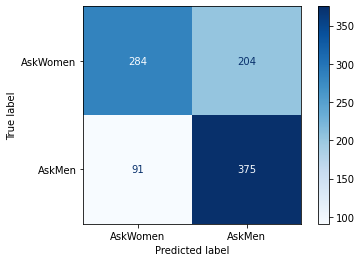

In [60]:
plot_confusion_matrix(rf, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['AskWomen', 'AskMen']);

In [61]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

I can now compute the accuracy, specificity, sensitivity and precision of the model:

In [62]:
accuracy_score(y_test, preds)

0.6907756813417191

As explained above, 69% of the predictions are accurate

In [63]:
spec = tn / (tn + fp)
spec

0.5819672131147541

the specificity is 0.58. 58% of the predictions are correctly classified as women(from the AskWomen subreddit)

let's check the sensitivity:

In [64]:
sens = tp / (tp + fn)
sens

0.8047210300429185

what about the precision

In [66]:
precision = precision_score(y_test, preds)
precision

0.6476683937823834

The precision is a measure of how reliable the model is when we use it to predict a result time after time

## Conclusion

The best model between logistic regression and random forest was the later, the random forest model.
I was only able to accurately predict the classification of a post 69% of the time.

To possibly improve this score, I'd probably need to stratify the classes to ensure that the minority class is accurately represented in our model.
I'd also probably need to do a combination of oversampling/undersampling of the minority or majority class.

In less technical terms, while I had a good feeling about finding a pattern in posts from the AskWomen subreddit and the AskWomen subreddit, I couldn't find a clear one. The most common words are pretty similar in both subreddit with generic words like women/men, like, know, feel. 

The context is important here because this is mainly a forum where people ask questions: "Do you men fee like/Do you women feel like...?" Consequently, these posts don't reflect the way customers would comment on a product/service.

Another approach to improve this model would be to perform a sentiment analysis to see the differences in both subreddits and get more representative data, like actual reviews.

Overall, I pretty much consider this test as a failure and I hope I won't get fired !